# Tarea 2: NLP, RNNs y Transformer

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import re

import numpy as np              # Procesamiento numérico
import pandas as pd             # Manipulación de conjuntos de datos
import matplotlib.pyplot as plt # Gráficos

import matplotlib.ticker as ticker

from tqdm import tqdm

from torch.utils.data import DataLoader, Subset

import torch
import torch.nn as nn
import torch.nn.functional as F

## Carga del dataset

Para la tarea se utilizará el dataset IMDB, el cual consiste en reseñas de películas con sus respectivas etiquetas de si es una reseña positiva o negativa.

El dataset se encuentra disponible en HuggingFace, asi que se puede cargar directamente.

**Nota:** Para descargar el dataset se tiene que instalar previamente la librería "datasets"

In [3]:
from datasets import load_dataset

c:\Users\Bruno\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
dataset = load_dataset("stanfordnlp/imdb")

In [5]:
data_train = pd.DataFrame(dataset["train"])
data_test = pd.DataFrame(dataset["test"])

# shuffle datasets

data_train = data_train.sample(frac=1).reset_index(drop=True)
data_test = data_test.sample(frac=1).reset_index(drop=True)

data_train.head()

,text,label
0,This was on at 2 or so In the morning one Satu...,1
1,Note: These comments are for people who have s...,1
2,"Following the brilliant ""Goyôkiba"" (aka. ""Hanz...",1
3,I'll make this short and sweet....this movie s...,0
4,This movie shows how racist John Singleton is....,0


In [6]:
# fraction dataset

fraction = 1
data_train = data_train.sample(frac=fraction).reset_index(drop=True)
data_test = data_test.sample(frac=fraction).reset_index(drop=True)

In [7]:
# tokenization
from nltk.tokenize import word_tokenize
import nltk
from bs4 import BeautifulSoup

nltk.download('punkt')

token_data_train = data_train.copy()
token_data_test = data_test.copy()

def clean_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text(separator=" ")
    # Remove special characters and multiple spaces
    text = re.sub(r'[^a-zA-Z0-9\s.,]', ' ', text)
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    # Convert text to lowercase
    text = text.lower()
    return text.strip()

token_data_train["text"] = token_data_train["text"].apply(clean_text)
token_data_test["text"] = token_data_test["text"].apply(clean_text)

token_data_train["text"] = token_data_train["text"].apply(word_tokenize)
token_data_test["text"] = token_data_test["text"].apply(word_tokenize)

token_data_train.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Bruno\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\Bruno\AppData\Local\Temp\ipykernel_11260\1763248502.py:13: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text(separator=" ")


,text,label
0,"[this, is, an, excellent, film, about, a, trad...",1
1,"[astonishing, screams, the, la, times, from, t...",0
2,"[i, don, t, know, if, i, m, just, weird, ,, bu...",1
3,"[i, honestly, had, no, idea, that, the, notori...",0
4,"[i, had, to, register, for, imdb, just, to, po...",0


In [8]:
# vocabulary
from collections import Counter

vocab = Counter()

for text in token_data_train["text"]:
    vocab.update(text)

In [9]:
# Define the vocabulary size based on the most common words
vocab_size = 20000

# Get the most common words up to the specified vocabulary size
most_common_words = vocab.most_common(vocab_size)
print(most_common_words[:10])

# Create word-to-index mapping with padding and unknown tokens
word_to_index = {word: index + 2 for index, (word, count) in enumerate(most_common_words)}
word_to_index["<PAD>"] = 0
word_to_index["<UNK>"] = 1

# Create index-to-word mapping
index_to_word = {index: word for word, index in word_to_index.items()}
index_to_word[0] = "<PAD>"
index_to_word[1] = "<UNK>"

# Add 2 to the vocabulary size for the padding and unknown tokens
vocab_size += 2

# Define a function to encode text using the word-to-index mapping
def encode_text(text):
    return [word_to_index.get(word, 1) for word in text]

# Apply the encoding function to the 'text' column of token_data_train and token_data_test
token_data_train["text"] = token_data_train["text"].apply(encode_text)
token_data_test["text"] = token_data_test["text"].apply(encode_text)

# Display the modified token_data_train
token_data_train.head()

[('the', 336136), (',', 275888), ('.', 269453), ('and', 164054), ('a', 162713), ('of', 145851), ('to', 135700), ('is', 107326), ('it', 96103), ('in', 93922)]


,text,label
0,"[13, 9, 37, 324, 22, 46, 6, 2021, 771, 699, 21...",1
1,"[5175, 3787, 2, 1054, 213, 40, 2, 997, 7, 2, 2...",0
2,"[12, 92, 25, 125, 49, 12, 146, 45, 901, 3, 21,...",1
3,"[12, 1243, 70, 60, 327, 14, 2, 2823, 1, 4, 773...",0
4,"[12, 70, 8, 8484, 18, 902, 45, 8, 1192, 6, 920...",0


In [10]:
def pad_text(text, length):
    return text[:length] if len(text) > length else text + [0] * (length - len(text))

In [11]:
# padding

text_max_length = np.max(token_data_train["text"].apply(len))
text_mean_length = int(np.mean(token_data_train["text"].apply(len)))
text_median_length = int(np.median(token_data_train["text"].apply(len)))

print(f"Max length: {text_max_length}")
print(f"Mean length: {text_mean_length}")
print(f"Median length: {text_median_length}")

token_data_train["text"] = token_data_train["text"].apply(pad_text, length=text_median_length//4)
token_data_test["text"] = token_data_test["text"].apply(pad_text, length=text_max_length)

token_data_train.head()

Max length: 2699
Mean length: 260
Median length: 194


,text,label
0,"[13, 9, 37, 324, 22, 46, 6, 2021, 771, 699, 21...",1
1,"[5175, 3787, 2, 1054, 213, 40, 2, 997, 7, 2, 2...",0
2,"[12, 92, 25, 125, 49, 12, 146, 45, 901, 3, 21,...",1
3,"[12, 1243, 70, 60, 327, 14, 2, 2823, 1, 4, 773...",0
4,"[12, 70, 8, 8484, 18, 902, 45, 8, 1192, 6, 920...",0


In [12]:
# create validation set

validation_size = 0.2
validation_samples = int(len(token_data_train) * validation_size)

final_val = token_data_train[:validation_samples]
final_train = token_data_train[validation_samples:]
final_test = token_data_test

In [13]:
final_train.reset_index(drop=True, inplace=True)
final_train.head()

,text,label
0,"[10, 15, 6, 674, 543, 8, 862, 581, 11, 6, 741,...",1
1,"[13, 9, 32, 7, 2, 87, 1708, 103, 12, 141, 127,...",1
2,"[12, 199, 13, 16, 6, 89, 327, 21, 3, 413, 3, 1...",0
3,"[42, 9, 60, 143, 6, 157, 17, 408, 1, 2446, 689...",1
4,"[4404, 9, 270, 11, 2, 391, 299, 493, 7, 1, 1, ...",0


 Por motivos de costo computacional y tiempo de entrenamiento, para la tarea pueden considerar una proporción del dataset,  por ejemplo el 10%. Pero tenga en consideración que si el tamaño del dataset es muy pequeño el rendimiento del modelo se verá afectado negativamente.

In [14]:
# PyTorch datasets

from torch.utils.data import Dataset

class IMDBDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return torch.tensor(self.data["text"][index]), torch.tensor(self.data["label"][index])

In [45]:
train_dataset = IMDBDataset(final_train)
val_dataset = IMDBDataset(final_val)
test_dataset = IMDBDataset(final_test)

# Report split sizes
print('Training set has {} instances'.format(len(final_train)))
print('Validation set has {} instances'.format(len(final_val)))
print('Test set has {} instances'.format(len(final_test)))

# PyTorch dataloaders

batch_size = 128

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Training set has 20000 instances
Validation set has 5000 instances
Test set has 25000 instances


## Parte 1: Redes Neuronales Recurrentes (RNNs)

### Actividad 1

Responda las siguientes preguntas:


*   ¿Cuáles son las principales características de las redes neuronales recurrentes?

    **Respuesta:** Las redes neuronales recurrentes, como su nombre indica, poseen conexiones recurrentes
    lo que permite que la red mantenga una memoria de los datos que ha procesado previamente,
    de forma que el _output_ en un estado particual esta influenciado no solo por su _input_ actual
    sino también por los _inputs_ previos.
    
    Las RNN tienen la capacidad de recibir _inputs_ de longitud variable y producir _outputs_ de longitud variable.

*   ¿Cuáles son las desventajas y limitaciones de las redes RNNs?

    **Respuesta:** Las RNNs sufren del problema de desvanecimiento y explosión del gradiente, lo que
    dificulta el entrenamiento de la red. Además, las RNNs tienen dificultades para mantener
    la memoria a largo plazo, lo que limita su capacidad para recordar información relevante
    de _inputs_ muy antiguos. Por el contrario, las RNNs también tienen problemas para olvidar
    información irrelevantes de _inputs_ recientes que no son relevantes para el _output_.

*   Menciona y describa brevemente al menos dos variantes a la arquitectura de RNNs simples.

    **Respuesta:** LSTM: Las redes LSTM (Long Short-Term Memory) son una variante de las RNNs que
    intentan solucionar el problema de la memoria a largo plazo. Las LSTM poseen una estructura
    más compleja que las RNNs tradicionales, con una estructura de celdas que permiten mantener
    la memoria a largo plazo y olvidar información irrelevante.

    GRU: Las redes GRU (Gated Recurrent Unit) son una variante de las RNNs que intentan simplificar
    la estructura de las LSTM, eliminando la estructura de celdas y manteniendo solo las puertas
    de olvido y actualización. Las GRU son más simples que las LSTM y tienen menos parámetros,
    lo que las hace más fáciles de entrenar y menos propensas al sobreajuste.

    Modelos de atención: Los modelos de atención son una variante de las RNNs que permiten
    que la red se enfoque en partes específicas de la secuencia de _inputs_ para generar el _output_,
    asignando pesos a los _inputs_ en vez de asignar el mismo peso a todos los _inputs_ como lo hacen
    las RNNs tradicionales. 

### Actividad 2

Implemente una red RNN simple y realice su entrenamiento con el dataset preprocesado. Para el pre-procesamiento use el método de la Actividad 1.

La siguiente celda contiene el esqueleto de la red. Puede usarlo como referencia para su implementación o realizar una propia.

In [81]:
class SimpleRNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, output_size, dropout=0.2):
        super(SimpleRNN, self).__init__()

        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(vocab_size, embedding_size)

        self.e2h = nn.Linear(embedding_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Embedding
        x = self.embedding(x)
        
        # RNN
        hidden = torch.zeros(x.size(0), self.hidden_size).to(x.device)
        for t in range(x.size(1)):
            hidden = torch.relu(self.e2h(x[:, t, :]) + self.h2h(hidden))
            hidden = self.dropout(hidden)
        
        out = self.h2o(hidden)
        
        return out

In [82]:
simple_model = SimpleRNN(vocab_size, 128, 128, 1, dropout=0.2)

In [83]:
criterion = nn.BCEWithLogitsLoss()
lr = 0.005
optimizer = torch.optim.Adam(simple_model.parameters(), lr=lr)

In [84]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
simple_model.to(device)

SimpleRNN(
  (embedding): Embedding(20002, 128)
  (e2h): Linear(in_features=128, out_features=128, bias=True)
  (h2h): Linear(in_features=128, out_features=128, bias=True)
  (h2o): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [85]:
def train(num_epochs, model, criterion, optimizer, train_dataloader, val_dataloader):
    losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        for i, (texts, labels) in enumerate(tqdm(train_dataloader)):
            if torch.isnan(texts).any() or torch.isinf(texts).any():
                print(f"Found NaN or inf in texts at iteration {i}")
            if torch.isnan(labels).any() or torch.isinf(labels).any():
                print(f"Found NaN or inf in labels at iteration {i}")
            if (texts >= vocab_size).any():
                print(f"Found out-of-range values in texts at iteration {i}")
            texts = texts.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            output = model(texts)
            output = output.squeeze()  # Remove the extra dimension from the output

            loss = criterion(output, labels.float())  # Compute the loss
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Apply gradient clipping
            optimizer.step()

        losses.append(loss.item())
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

        model.eval()

        with torch.no_grad():
            for i, (texts, labels) in enumerate(tqdm(val_dataloader)):
                texts = texts.to(device)
                labels = labels.to(device)

                output = model(texts)
                output = output.squeeze()

                val_loss = criterion(output, labels.float())

        val_losses.append(val_loss.item())
        print('Epoch [{}/{}], Validation Loss: {:.4f}'.format(epoch+1, num_epochs, val_loss.item()))

    return (losses, val_losses)

In [86]:
losses, val_losses = train(5, simple_model, criterion, optimizer, train_dataloader, val_dataloader)

100%|██████████| 157/157 [00:09<00:00, 15.84it/s]


Epoch [1/5], Loss: 0.5958


100%|██████████| 40/40 [00:00<00:00, 58.48it/s]


Epoch [1/5], Validation Loss: 0.9763


100%|██████████| 157/157 [00:09<00:00, 16.40it/s]


Epoch [2/5], Loss: 0.6788


100%|██████████| 40/40 [00:00<00:00, 59.61it/s]


Epoch [2/5], Validation Loss: 0.6436


100%|██████████| 157/157 [00:09<00:00, 16.45it/s]


Epoch [3/5], Loss: 0.6115


100%|██████████| 40/40 [00:00<00:00, 59.97it/s]


Epoch [3/5], Validation Loss: 0.7630


100%|██████████| 157/157 [00:09<00:00, 16.52it/s]


Epoch [4/5], Loss: 0.5697


100%|██████████| 40/40 [00:00<00:00, 59.35it/s]


Epoch [4/5], Validation Loss: 0.5190


100%|██████████| 157/157 [00:09<00:00, 16.53it/s]


Epoch [5/5], Loss: 0.6304


100%|██████████| 40/40 [00:00<00:00, 59.35it/s]

Epoch [5/5], Validation Loss: 0.6137


In [97]:
# PATH = './simple_rnn.pth'
# torch.save(simple_model.state_dict(), PATH)

In [2]:
# PATH = './simple_rnn.pth'
# simple_model = SimpleRNN(vocabulary_size, 128, 128, 1)
# simple_model.load_state_dict(torch.load(PATH))
# simple_model.to(device)

In [24]:
# plot losses

def plot(losses, val_losses=None, time_unit="Epoch"):

    if val_losses is not None:
        plt.plot(losses, label="Training loss")
        plt.plot(val_losses, label="Validation loss")
        plt.legend()

        plt.xlabel("Iteration")
        plt.ylabel("Loss")

    else:
        plt.plot(losses, label="Loss")

        plt.xlabel(time_unit)
        plt.ylabel("Loss")

    plt.show()

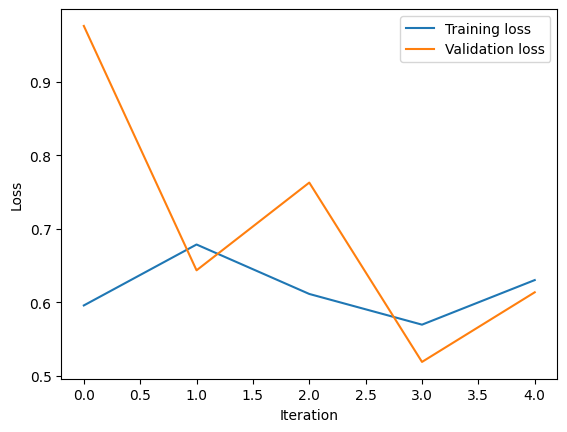

In [89]:
plot(losses, val_losses)

In [70]:
# Test accuracy

def test(model, dataloader):

    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for texts, labels in tqdm(dataloader):
            texts = texts.to(device)
            labels = labels.to(device)

            output = model(texts)
            output = output.squeeze()

            predictions = torch.round(torch.sigmoid(output))

            total += labels.size(0)
            correct += (predictions == labels).sum().item()

    accuracy = correct / total
    print(f"Test accuracy: {accuracy * 100:.2f}%")

In [87]:
test(simple_model, test_dataloader)

100%|██████████| 196/196 [02:52<00:00,  1.13it/s]

Test accuracy: 67.96%


In [88]:
test(simple_model, train_dataloader)

100%|██████████| 157/157 [00:03<00:00, 43.15it/s]

Test accuracy: 81.22%


### Actividad 3

Implemente una red variante al RNN clásico, como un LSTM, GRU, Bi-LSTM, entre otros. Realice el entrenamiento del modelo con el mismo dataset. Realice un breve análisis sobre las diferencias en términos de los resultados, tiempo de ejecución y aspectos que le parezcan relevantes, entre la red implementada en la actividad previa y la red implementada en esta actividad.

In [90]:
class VariantRNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, output_size, dropout=0.2):
        super(VariantRNN, self).__init__()

        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.update_gate = nn.Linear(embedding_size + hidden_size, hidden_size)
        self.reset_gate = nn.Linear(embedding_size + hidden_size, hidden_size)
        self.new_memory = nn.Linear(embedding_size + hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Embedding
        x = self.embedding(x)
        
        # RNN
        hidden = torch.zeros(x.size(0), self.hidden_size).to(x.device)
        for t in range(x.size(1)):
            combined = torch.cat((x[:, t, :], hidden), dim=1)
            update = torch.sigmoid(self.update_gate(combined))
            reset = torch.sigmoid(self.reset_gate(combined))
            memory = torch.tanh(self.new_memory(torch.cat((x[:, t, :], reset * hidden), dim=1)))
            hidden = (1 - update) * hidden + update * memory
            hidden = self.dropout(hidden)
        
        out = self.fc(hidden)
        
        return out

In [91]:
variant_model = VariantRNN(vocab_size, 128, 128, 1, dropout=0.2)
variant_model.to(device)

VariantRNN(
  (embedding): Embedding(20002, 128)
  (update_gate): Linear(in_features=256, out_features=128, bias=True)
  (reset_gate): Linear(in_features=256, out_features=128, bias=True)
  (new_memory): Linear(in_features=256, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [92]:
criterion = nn.BCEWithLogitsLoss()
lr = 0.005
optimizer = torch.optim.Adam(variant_model.parameters(), lr=lr)

In [93]:
losses, val_losses = train(5, variant_model, criterion, optimizer, train_dataloader, val_dataloader)

100%|██████████| 157/157 [00:20<00:00,  7.59it/s]


Epoch [1/5], Loss: 0.6141


100%|██████████| 40/40 [00:01<00:00, 24.49it/s]


Epoch [1/5], Validation Loss: 0.5336


100%|██████████| 157/157 [00:20<00:00,  7.59it/s]


Epoch [2/5], Loss: 0.5776


100%|██████████| 40/40 [00:01<00:00, 24.75it/s]


Epoch [2/5], Validation Loss: 0.4505


100%|██████████| 157/157 [00:20<00:00,  7.58it/s]


Epoch [3/5], Loss: 0.6192


100%|██████████| 40/40 [00:01<00:00, 24.65it/s]


Epoch [3/5], Validation Loss: 0.3973


100%|██████████| 157/157 [00:20<00:00,  7.60it/s]


Epoch [4/5], Loss: 0.4382


100%|██████████| 40/40 [00:01<00:00, 24.37it/s]


Epoch [4/5], Validation Loss: 0.4271


100%|██████████| 157/157 [00:20<00:00,  7.56it/s]


Epoch [5/5], Loss: 0.5238


100%|██████████| 40/40 [00:01<00:00, 24.15it/s]

Epoch [5/5], Validation Loss: 0.5041


In [98]:
# PATH = './variant_rnn.pth'
# torch.save(variant_model.state_dict(), PATH)

In [ ]:
# PATH = './variant_rnn.pth'
# variant_model = VariantRNN(vocabulary_size, 128, 128, 1)
# variant_model.load_state_dict(torch.load(PATH))
# variant_model.to(device)

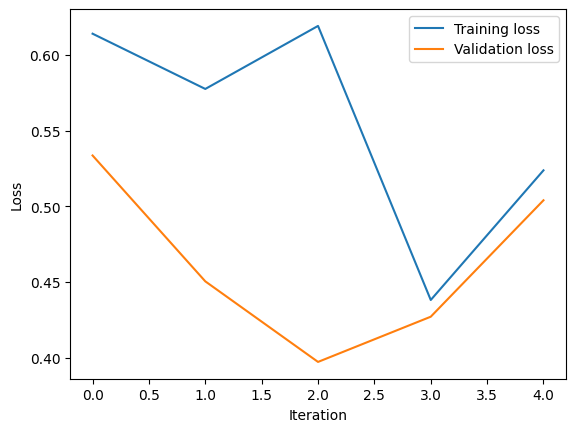

In [94]:
plot(losses, val_losses)

In [95]:
test(variant_model, test_dataloader)

100%|██████████| 196/196 [08:02<00:00,  2.46s/it]

Test accuracy: 72.26%


In [96]:
test(variant_model, train_dataloader)

100%|██████████| 157/157 [00:07<00:00, 20.58it/s]

Test accuracy: 83.78%


#### SimpleRNN vs VariantRNN

Los resultados obtenidos por VariantRNN son mejores que los de la RNN simple. Para VariantRNN se usó
una RNN tipo GRU, que es una variante de las RNNs que intenta solucionar los problemas de las RNNs
tradicionales. En este caso, la GRU obtuvo mejores resultados que la RNN simple, con una precisión
considerablemente mejor, pero tampoco con una diferencia enorme.

En cuanto a los tiempos de entrenamiento, se tiene que fueron bastante parecidos, aunque levemente
más lento el entrenamiento de la GRU, así como también en el tiempo de testeo.

Finalmente, en términos de implementación en código, son realmente muy parecidos, con la única diferencia
de que en la GRU se usa una capa de tipo GRU en vez de una capa de tipo RNN.

Cabe destacar que en ambos casos mi entrenamiento tuvo problemas de _overfitting_ y de gradientes, ya
que el _validation_loss_ se volvía muy inestable y no lograba disminuir de forma constante, por lo que
opté por entrenar con un número de _epochs_ menor para evitar el _overfitting_ y secuencias de texto
más cortas para evitar problemas con los gradientes.

## Parte 2: Transformer

### Actividad 4

Responda las siguientes preguntas:



*   ¿Cuáles son los principales aspectos de las redes Transformer?
¿Qué desafíos específicos de las RNNs intenta superar la arquitectura de los Transformers?

    **Respuesta:** Los Transformers son una arquitectura de redes neuronales que intenta solucionar
    los problemas de las RNNs, como el desvanecimiento y explosión del gradiente, la dificultad para
    mantener la memoria a largo plazo y la dificultad para paralelizar el entrenamiento. Los Transformers
    eliminan las conexiones recurrentes de las RNNs y las reemplazan por capas de atención, que permiten
    que la red se enfoque en partes específicas de la secuencia de _inputs_ para generar el _output_,
    asignando pesos a los _inputs_ en vez de asignar el mismo peso a todos los _inputs_ como lo hacen
    las RNNs tradicionales, además de tenber todos los _inputs_ de la secuencia a "distancia 1" entre
    sí, no como en la RNN, donde su distancia depende de su posicionamiento.
    Los Transformers también permiten paralelizar el entrenamiento, lo que acelera el proceso de
    +entrenamiento y permite entrenar modelos más grandes.

*   ¿Cuáles son las diferencias entre las capas cross-attention y self-attention?

    **Respuesta:** La self-attention es una capa de los Transformers que permite que la red se enfoque
    en partes específicas de la secuencia de _inputs_ para generar el _output_, asignando pesos
    diferentes a los _inputs_. La cross-attention es una variante de la self-attention que permite
    que la red se enfoque en partes específicas de dos secuencias de _inputs_ para generar el
    _output_, asignando pesos diferentes a los _inputs_ de ambas secuencias.


*   ¿Cuáles son las principales características del encoder y el decoder de una red Transformer?

    **Respuesta:** El encoder de un Transformer es la parte de la red que se encarga de procesar
    la secuencia de _inputs_ y extraer las características relevantes de la secuencia. El encoder
    está compuesto por capas de atención y capas feedforward, que permiten que la red se enfoque
    en partes específicas de la secuencia de _inputs_ para generar el _output_ y que la red aprenda
    representaciones no lineales de los _inputs_.
    Por otro lado, el decoder de un Transformer es la parte de la red que se encarga de generar
    la secuencia de _outputs_ a partir de las características extraídas por el encoder. El decoder
    está compuesto por capas de atención, capas feedforward y una capa de cross-attention, que
    permiten que la red se enfoque en partes específicas de la secuencia de _inputs_ y de la secuencia
    de _outputs_ para generar el _output_.

*   ¿En qué casos se aplica modelos de tipo encoder? En qué casos se aplica modelos de tipo decoder? ¿En qué casos se aplica modelos de tipo encoder decoder? Responda y justifique su respuesta brevemente.

    **Respuesta:** Los modelos de tipo encoder se aplican en tareas de clasificación de texto, donde
    la salida no es otra secuencia de texto, sino una representación densa, como una etiqueta
    o un vector. Los modelos de tipo decoder se aplican en tareas de generación de texto o descripción
    de imágenes, donde la salida es una secuencia que se genera a partir de un _input_ denso.
    Los modelos de tipo encoder-decoder se aplican en tareas de traducción de texto, donde la salida
    es otra secuencia de texto y se necesita extraer características de la secuencia de _inputs_ para generar el _output_.

### Actividad 5

En particular, la tarea será sobre generación de reseñas. Es decir que tendrán que implementar una red Transformer y entrenarla con el dataset IMDB para generar texto de reseñas de películas.

A medida que progresa el entrenamiento, muestre algunas instancias de salida del texto generado por el modelo. Para ello considere los puntos inicial, intermedio y final del entrenamiento. Realice un análisis sobre el texto generado y explique brevemente cómo el modelo es capaz de generar texto de reseñas.

Es importante que argumente su elección de los parámetros e hiperparámetros que vaya a utilizar, tales como: cantidad de capas, cantidad de neuronas por capa, función de activación, función de pérdida, etc. En particular, describa el método utilizado para la tokenización de los datos.

Actividad realizada en base a: https://github.com/karpathy/ng-video-lecture/blob/master/gpt.py

In [6]:
# tokenization
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
import nltk

nltk.download('punkt')

token_data_train = data_train.copy()
token_data_test = data_test.copy()

# concatenate both datasets

token_data = pd.concat([data_train, data_test], ignore_index=True)

def clean_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text(separator=" ")
    # Remove special characters and multiple spaces
    text = re.sub(r'[^a-zA-Z0-9\s.,]', ' ', text)
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

token_data["text"] = token_data["text"].apply(clean_text)
token_data["text"] = token_data["text"].apply(word_tokenize)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Bruno\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\Bruno\AppData\Local\Temp\ipykernel_7464\1318973262.py:17: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text(separator=" ")


In [7]:
SEQUENCE_LENGTH = 64


def df2sequences(token_data, data_column="text"):
    # Create a list of sequences of words from the 'text' column

    list_of_lists = token_data[data_column].tolist()

    # Add a newline character to the beginning of each sequence

    for i in range(len(list_of_lists)):
        list_of_lists[i].insert(0, "\n")

    # Merge all sequences into a single list

    all_words = [word for sequence in list_of_lists for word in sequence]

    # Remove first newline character

    all_words.pop(0)

    # Subdivide the list into smaller lists of SEQUENCE_LENGTH words

    sequences = [all_words[i:i+SEQUENCE_LENGTH] for i in range(len(all_words)-SEQUENCE_LENGTH)]

    return (all_words, sequences)

all_words, sequences = df2sequences(token_data)

In [8]:
# vocabulary
from collections import Counter

words_count = Counter(all_words)

# Use only the first 20,000 most common words

vocab = [word for word, count in words_count.most_common(20000)]
vocab.append("<UNK>") # Add an unknown token at the end of the list

vocab_size = len(vocab)

# Create word-to-index and index-to-word mappings

word_to_int = {word: index for index, word in enumerate(vocab)}
int_to_word = {index: word for word, index in word_to_int.items()}

print(f"Vocabulary size: {vocab_size}")
print(vocab[:10])

Vocabulary size: 20001
['the', ',', '.', 'and', 'a', 'of', 'to', 'is', 'in', 'I']


In [9]:
# Define a function to calculate distance between words
# this will allow us to approximate a word that is not in the vocabulary to
# the closest word in the vocabulary

def word_distance(word1, word2):
    distance = 0
    if len(word1) < len(word2):
        for i in range(len(word1)):
            if word1[i] != word2[i]:
                distance += 1
    else:
        for i in range(len(word2)):
            if word1[i] != word2[i]:
                distance += 1
    distance += abs(len(word1) - len(word2))
    return distance

# Find closest word in the vocabulary

def find_closest_word(word, vocab):
    closest_word = None
    min_distance = float('inf')
    for vocab_word in vocab:
        if abs(len(word) - len(vocab_word)) >= min_distance:
            continue
        distance = word_distance(word, vocab_word)
        if distance < min_distance:
            closest_word = vocab_word
            min_distance = distance
    return closest_word

In [10]:
def create_approx_encoding(word_to_int, vocab):
    approx_word_to_int = {}
    for word in vocab:
        if len(approx_word_to_int) == len(word_to_int):
            break
        if word not in word_to_int.keys() and word not in approx_word_to_int.keys():
            closest_word = find_closest_word(word, word_to_int.keys())
            approx_word_to_int[word] = word_to_int[closest_word]
    return approx_word_to_int

In [11]:
# PyTorch datasets

from torch.utils.data import Dataset

class TextDataset(Dataset):
    def __init__(self, samples, word_to_int, approx_encoding=None):
        self.samples = samples
        self.word_to_int = word_to_int
        self.approx_encoding = approx_encoding

    def get_approx_encoding_output(self, word):
        if self.approx_encoding is None or word not in self.approx_encoding.keys():
            return self.word_to_int["<UNK>"]
        return self.approx_encoding[word]

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        input_seq = torch.LongTensor([self.word_to_int[word] if word in self.word_to_int.keys() else self.get_approx_encoding_output(word) for word in sample[:-1]])
        target_seq = torch.LongTensor([self.word_to_int[word] if word in self.word_to_int.keys() else self.get_approx_encoding_output(word) for word in sample[1:]])
        return input_seq, target_seq

In [12]:
# Use a fraction of all sequences for training, due to the large size of the dataset

fraction = 0.1
train_samples = int(len(sequences) * fraction)

train_data = sequences[:train_samples]

In [13]:
BATCH_SIZE = 64

generation_dataset = TextDataset(train_data, word_to_int)

In [14]:
generation_dataloader = DataLoader(generation_dataset, batch_size=BATCH_SIZE, shuffle=True)

Como se puede observar, el modelo utilizado para la tokenización es word_to_int y int_to_word, que son diccionarios que mapean palabras a enteros y viceversa. Además, se utilizan los métodos encode y decode para convertir texto a enteros y viceversa. Previamente el texto fue preprocesado uniendo todas las reviews entre sí con "\n" y se tokenizó con el método word_tokenize de la librería nltk, de forma que el modelo fue entrenado sobre unidades de palabras en vez de caracteres.

In [15]:
def generate_triangular_mask(size):
    mask = torch.tril(torch.ones(size, size))
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [16]:
class PositionalEncoding(nn.Module):
    def __init__(self, max_len, d_model, dropout=0.2):
        super(PositionalEncoding, self).__init__()

        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size, n_embd, dropout=0.2):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(SEQUENCE_LENGTH, SEQUENCE_LENGTH)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size, n_embd, dropout=0.2):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size, n_embd) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out
    
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)
    
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size, n_embd)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

In [17]:
class MyModel(nn.Module):

    def __init__(self, vocab_size, n_embd, n_layer, n_head, block_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None, criterion=nn.CrossEntropyLoss()):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = criterion(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -SEQUENCE_LENGTH:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)

        output_list = idx[0].tolist()
        output_text = ""
        for item in output_list:
            word = int_to_word[item]
            if (word.lower() == "s" or (word.lower() == "t" and output_text[-1].lower() == "n")
                or (word.lower() == "m" and output_text[-1].lower() == "i")):
                output_text += "'" + word
            elif word in [",", ".", "!", "?", ":", ";"]:
                output_text += word
            else:
                output_text += " " + word

        print(output_text)

Justificación de hiperparámetros:
- Cantidad de capas: Se utilizan 2 capas para el decoder, ya que se considera que es suficiente para la tarea y para evitar el sobreajuste, teniendo en cuenta también el tiempo de entrenamiento.
- Cantidad de neuronas por capa: Se utilizan 128 neuronas por capa, ya que se considera que es suficiente para la tarea, para evitar el sobreajuste y no tener tiempo de entrenamiento excesivo.
- Función de activación: Se utiliza la función de activación ReLU, ya que es una función no lineal que permite que la red aprenda representaciones no lineales de los _inputs_.
- Número de _heads_: Se utilizan 4 _heads_ para la capa de atención, ya que se considera que es suficiente para la tarea, para evitar el sobreajuste y no tener tiempo de entrenamiento excesivo.
- Función de pérdida: Se utiliza la función de pérdida CrossEntropy, ya que es una función adecuada para problemas de clasificación multiclase.
- Optimizador: Se utiliza el optimizador Adam, ya que es un optimizador que se adapta a la tasa de aprendizaje de forma dinámica y es adecuado para problemas de clasificación multiclase.

In [18]:
EPOCHS = 3
LR = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyModel(vocab_size, 128, 2, 4, SEQUENCE_LENGTH)
model.to(device)

MyModel(
  (token_embedding_table): Embedding(20001, 128)
  (position_embedding_table): Embedding(64, 128)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x Head(
            (key): Linear(in_features=128, out_features=32, bias=False)
            (query): Linear(in_features=128, out_features=32, bias=False)
            (value): Linear(in_features=128, out_features=32, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (proj): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ffwd): FeedFoward(
        (net): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=128, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
   

In [19]:
# No training


context = torch.zeros((1, 1), dtype=torch.long, device=device)
model.generate(context, max_new_tokens=100)

 the husbands shell gratuitous homosexuality assistant debates wondered goody kidnappers School crush this sniffing incorporates lousy interfere slob Han Lines bravery Master Wives distress call baffled 60 relevant recognise write technology instantly finds bicycle Apart melt Brits catatonic must honorable Hawkins Alexandra cutesy downside perpetrator disgraced Evans religiously orthodox injecting 1920s output Toons painstakingly evil vessel Fanny drastically ingredient 77 Sharif Watts Wicker reruns previously similarity November communications drunks cuteness pleasantly Bake swallow readily bases Amir compose poorest boots Deal amongst preachy definately Typical FAR gave Lumet machina f pleaser sneaks Farrah Sylvia exploring Sirk Fuller Daffy mad Zatoichi Tingle Dozen


In [20]:
def train(model, epochs, criterion, optimizer, train_dataloader, accumulation_steps=1):
    losses = []
    counter = 0
    for epoch in range(epochs):
        model.train()
        for input_sequence, target_sequence in tqdm(train_dataloader):
            counter +=1
            input_sequence = input_sequence.to(device)
            target_sequence = target_sequence.to(device)

            output, loss = model(input_sequence, target_sequence, criterion=criterion)
            
            loss.backward()

            if (counter + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            if (counter + 1) % (len(train_dataloader) // 5) == 0:
                losses.append(loss.item())
                print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}")

        print(f"Epoch [{epoch+1}/{epochs}]")
        print("Example text at the end of epoch:")
        context = torch.zeros((1, 1), dtype=torch.long, device=device)
        model.generate(context, max_new_tokens=100)
        
    return losses

In [21]:
losses = train(model, EPOCHS, nn.CrossEntropyLoss(), torch.optim.Adam(model.parameters(), lr=LR), generation_dataloader, accumulation_steps=4)

 20%|██        | 4040/20196 [02:45<10:24, 25.86it/s]

Epoch [1/3], Loss: 4.387157440185547


 40%|████      | 8081/20196 [05:21<07:43, 26.12it/s]

Epoch [1/3], Loss: 3.887908458709717


 60%|██████    | 12119/20196 [07:56<05:11, 25.94it/s]

Epoch [1/3], Loss: 3.5189108848571777


 80%|████████  | 16160/20196 [10:32<02:36, 25.83it/s]

Epoch [1/3], Loss: 3.457097291946411


100%|██████████| 20196/20196 [13:09<00:00, 25.60it/s]

Epoch [1/3], Loss: 3.3218629360198975
Epoch [1/3]
Example text at the end of epoch:


 the school at least could either entertain or stay that. After all, the remake of Van Damme is entertaining as the first few Americans in the first film The Little Mermaid. The Action scene is well, the last scene in <UNK> speech at all of the <UNK> Ones both the Korean Christians <UNK> for all of their faith, <UNK> the one of Christians I saw the <UNK> the <UNK> from the film. I know perfectly capturing it all surprised the other <UNK> Avoid, therefore, the carnage side value is hopelessly <UNK> samurai action


 20%|██        | 4040/20196 [02:36<10:25, 25.83it/s]

Epoch [2/3], Loss: 3.2444262504577637


 40%|███▉      | 8078/20196 [05:12<07:46, 25.95it/s]

Epoch [2/3], Loss: 3.2828235626220703


 60%|██████    | 12119/20196 [07:49<05:12, 25.81it/s]

Epoch [2/3], Loss: 3.126243829727173


 80%|████████  | 16157/20196 [10:25<02:35, 25.97it/s]

Epoch [2/3], Loss: 3.090932846069336


100%|██████████| 20196/20196 [13:02<00:00, 25.81it/s]

Epoch [2/3], Loss: 3.063394784927368
Epoch [2/3]
Example text at the end of epoch:


 the best life and should cause of now be were better given by chance to show something greater. Not only because it's full of bio electronic Bugs Bunny <UNK> he treats members. He's really funny. Screenplay is evidently two <UNK> <UNK> <UNK> <UNK> or something about some time or so much blood. The children are eventually slowly and how to Chinese fantasy about ethnic the bounty <UNK> and a real <UNK> into the <UNK> onto the story. The Dark <UNK> is normal fears. 
 This was complete with all 3 of the one


 20%|██        | 4040/20196 [02:36<10:25, 25.81it/s]

Epoch [3/3], Loss: 2.9731342792510986


 40%|███▉      | 8078/20196 [05:12<07:45, 26.05it/s]

Epoch [3/3], Loss: 3.033215045928955


 60%|█████▉    | 12116/20196 [07:46<05:06, 26.40it/s]

Epoch [3/3], Loss: 3.033606767654419


 80%|████████  | 16157/20196 [10:19<02:32, 26.46it/s]

Epoch [3/3], Loss: 3.087449789047241


100%|██████████| 20196/20196 [12:53<00:00, 26.11it/s]

Epoch [3/3], Loss: 3.059826374053955


Epoch [3/3]
Example text at the end of epoch:
 the whole thing. 
 A low rating scale, there is extremely silly. I guess someone who has the best friends with a few years ago. 
 This is not the genre I love, as for the case. It seems <UNK>, about love, and no longer sounds have a sack of crap, returned from the Black. The Cat, or awesome characters isn't really gorgeous, but i couldn't really put in the latter. The <UNK> at times and beautiful great. The oil well put the idea.


In [54]:
# Text example after training


context = torch.zeros((1, 1), dtype=torch.long, device=device)
model.generate(context, max_new_tokens=100)

 the mother in. Anne Marie Fahey is one of the most famous girl of the saddest yet unnamed movie not known to decide whether it will spell a <UNK> for anything he might be, since he <UNK> the <UNK> raise although we can't wait to get some films, consequently, a pretty short film although it may make up that makes t help but find out on earth or or independent companies re not really stupid enough context and <UNK> on a half way of sight is the <UNK> this is one of trying to put it


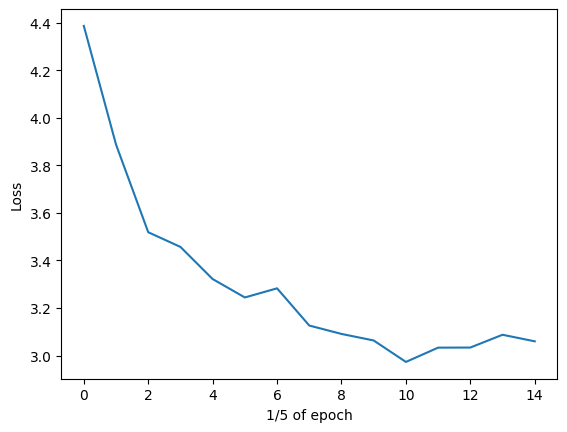

In [25]:
plot(losses, time_unit="1/5 of epoch")

In [26]:
# PATH = './text_generator_vd.pth'
# torch.save(model.state_dict(), PATH)

### Actividad 6

A partir del modelo generativo de la anterior actividad, realice los ajustes necesarios al modelo para mejorar la calidad de las reseñas generadas. Se espera que el modelo sea capaz de generar reseñas de mejor calidad en comparación a la actividad previa. Para ello, investigue y agregue otros datasets públicos de reseñas de películas u otro tipo.

In [27]:
PATH = './text_generator_vd.pth'
model_v2 = MyModel(vocab_size, 128, 2, 4, SEQUENCE_LENGTH)
model_v2.load_state_dict(torch.load(PATH))
model_v2.to(device)

MyModel(
  (token_embedding_table): Embedding(20001, 128)
  (position_embedding_table): Embedding(64, 128)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x Head(
            (key): Linear(in_features=128, out_features=32, bias=False)
            (query): Linear(in_features=128, out_features=32, bias=False)
            (value): Linear(in_features=128, out_features=32, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (proj): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ffwd): FeedFoward(
        (net): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=128, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
   

In [28]:
new_dataframe = pd.read_csv(os.path.join("data", "netflix_reviews.csv"))
new_dataframe.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,d3e47eba-2621-43bb-9ac2-8fd0ad6a2606,Peggy Khor,There is problem playing this video. Please tr...,1,0,8.114.0 build 19 50680,2024-05-14 23:26:05,8.114.0 build 19 50680
1,09eccc56-3b2f-4286-a395-ddd14da284d4,Dale Krawetz,Netflix is the awesomest app there is when it ...,5,0,NaN,2024-05-14 23:22:18,NaN
2,0c9a56b1-9c5d-404f-8f78-ce1bebd88e96,A Google user,Aside from the cost being ridiculous.. audio k...,3,1,8.114.0 build 19 50680,2024-05-14 23:05:19,8.114.0 build 19 50680
3,e065b74e-51e6-4502-ac9c-930ad8a6a064,"Okwor, Maranatha Isioma",Dear Netflix... Please it's about time you put...,2,0,8.105.0 build 15 50626,2024-05-14 22:40:55,8.105.0 build 15 50626
4,1fbf7664-efb6-4f76-a1bf-15c577b97f8d,Pieter Van kammen,Terrible,1,0,8.114.0 build 19 50680,2024-05-14 22:29:08,8.114.0 build 19 50680


In [29]:
fraction = 0.1
new_tokens = new_dataframe.sample(frac=fraction).reset_index(drop=True)

new_tokens["content"] = new_tokens["content"].apply(clean_text)
new_tokens["content"] = new_tokens["content"].apply(word_tokenize)

new_all_words, new_sequences = df2sequences(new_tokens, data_column="content")

new_words_count = Counter(new_all_words)

new_vocab = list(new_words_count.keys())

C:\Users\Bruno\AppData\Local\Temp\ipykernel_7464\1318973262.py:17: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text(separator=" ")


In [30]:
approx_encoding = create_approx_encoding(word_to_int, new_vocab)

In [31]:
NEW_BATCH_SIZE = 64

new_generation_dataset = TextDataset(new_sequences, word_to_int, approx_encoding)

new_generation_dataloader = DataLoader(new_generation_dataset, batch_size=NEW_BATCH_SIZE, shuffle=True)

In [32]:
NEW_LR = 0.001
NEW_EPOCHS = 1

new_losses = train(model_v2, NEW_EPOCHS, nn.CrossEntropyLoss(), torch.optim.Adam(model_v2.parameters(), lr=NEW_LR), new_generation_dataloader, accumulation_steps=4)

 20%|██        | 1162/5804 [00:44<03:01, 25.51it/s]

Epoch [1/1], Loss: 4.237789630889893


 40%|████      | 2323/5804 [01:29<02:13, 25.99it/s]

Epoch [1/1], Loss: 3.6652307510375977


 60%|██████    | 3484/5804 [02:13<01:29, 26.02it/s]

Epoch [1/1], Loss: 3.3686225414276123


 80%|███████▉  | 4642/5804 [02:58<00:44, 26.13it/s]

Epoch [1/1], Loss: 3.0960636138916016


100%|█████████▉| 5803/5804 [03:42<00:00, 25.97it/s]

Epoch [1/1], Loss: 3.0403237342834473


100%|██████████| 5804/5804 [03:42<00:00, 26.06it/s]


Epoch [1/1]
Example text at the end of epoch:
 the seasons of Caruso, Bake, etc ... and Hannibal again 
 remove the games than that but all the game is the way As throughout the world. Hard porn and if you just keep up your nose, or going round in the bottom of the were there in the way of the download are gone 
 This ape is screaming entertainment watching something for the current movies and gather after it's pauses everything was 
 Love that I love watching and how to view for an increasingly energy into a stable screaming. 
 Keep up


In [33]:
# Text example after training on new data


context = torch.zeros((1, 1), dtype=torch.long, device=device)
model.generate(context, max_new_tokens=100)

 the real thing boils down with him but it was riveting. Some dude in question Brian waving my personal side, despite its <UNK>'s <UNK> nature <UNK> I would have gained enough effort into a position to open about it as possible, and while the film maybe Slater has no chemistry with this film is not as funny as we ve got a dollar film points out after watching all through using an everyday level speaking to since. It's what a lot of an hour and getting want and a show <UNK> that I d need


Trying once more with another dataset

In [34]:
new_dataframe = pd.read_csv(os.path.join("data", "LINKEDIN_REVIEWS.csv"))
new_dataframe.head()

,Unnamed: 0,review_id,pseudo_author_id,author_name,review_text,review_rating,review_likes,author_app_version,review_timestamp
0,0,cd2c2a2c-750b-435c-823c-277a6dbcef2a,152618553977019693742,A Google user,Well designed app. It's much easier to use tha...,5,0,1.0.3,2011-04-07 15:57:52
1,1,ac8d5093-31ce-4f12-8c6b-ee79a06295ab,234382942865437071667,A Google user,Cool!,5,1,1.0.0,2011-04-07 15:59:50
2,2,bbae055c-f20b-4c01-b604-7cea72416a3a,174473604608358796368,A Google user,Great to finally see this on the market!,5,0,2.0.5,2011-04-07 16:16:02
3,3,38a13596-b208-423d-8d96-3199e1993138,286593453219054880269,A Google user,Great app,5,1,1.0.0,2011-04-07 16:22:27
4,4,9ddd29ce-b137-4286-9aa1-3bbdd0015e0a,167276875678680630145,A Google user,Finally! Would love a Homeycomb specific versi...,4,0,1.0.0,2011-04-07 17:41:58


In [35]:
fraction = 0.1
new_tokens = new_dataframe.sample(frac=fraction).reset_index(drop=True)

new_tokens["review_text"] = new_tokens["review_text"].apply(lambda x: str(x))
new_tokens["review_text"] = new_tokens["review_text"].apply(clean_text)
new_tokens["review_text"] = new_tokens["review_text"].apply(word_tokenize)

new_all_words, new_sequences = df2sequences(new_tokens, data_column="review_text")

new_words_count = Counter(new_all_words)

new_vocab = list(new_words_count.keys())

C:\Users\Bruno\AppData\Local\Temp\ipykernel_7464\1318973262.py:17: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text(separator=" ")


In [36]:
approx_encoding = create_approx_encoding(word_to_int, new_vocab)

In [37]:
NEW_BATCH_SIZE = 64

new_generation_dataset = TextDataset(new_sequences, word_to_int, approx_encoding)

new_generation_dataloader = DataLoader(new_generation_dataset, batch_size=NEW_BATCH_SIZE, shuffle=True)

In [38]:
NEW_LR = 0.001
NEW_EPOCHS = 1

new_losses = train(model_v2, NEW_EPOCHS, nn.CrossEntropyLoss(), torch.optim.Adam(model_v2.parameters(), lr=NEW_LR), new_generation_dataloader, accumulation_steps=4)

 20%|██        | 1123/5606 [00:43<02:52, 26.00it/s]

Epoch [1/1], Loss: 4.143250942230225


 40%|████      | 2245/5606 [01:26<02:09, 25.97it/s]

Epoch [1/1], Loss: 3.6534359455108643


 60%|██████    | 3367/5606 [02:09<01:26, 25.86it/s]

Epoch [1/1], Loss: 3.2463159561157227


 80%|████████  | 4486/5606 [02:52<00:42, 26.05it/s]

Epoch [1/1], Loss: 3.0877153873443604


100%|██████████| 5606/5606 [03:35<00:00, 26.00it/s]


Epoch [1/1], Loss: 3.069582223892212
Epoch [1/1]
Example text at the end of epoch:
 the premium version HA 
 This ape is cool 
 This Apes are the most essential apes that can happen all the time you forget what a responsible civilized person could be free, uses captures, except if we get away from a profile, or do that. 
 Just set up on WTC One. 
 Best Network ape 
 Amazing I now literally terrorist propaganda, loved the ape and I ve also. 
 Good Man and stop all the Good 
 Great 
 Thanks to get the action pursuit against, and later 
 Good


In [39]:
# Text example after training on new data


context = torch.zeros((1, 1), dtype=torch.long, device=device)
model.generate(context, max_new_tokens=100)

 the book of plot and was clearly over the years, they made the fact that this movie would be a belief that should have been sold at the local video store accidentally hit by animals. It was most likely to go to live in a long ballet and ends up we anticipate. Soon <UNK> and <UNK> on the <UNK> there are on a <UNK> and inside <UNK> at the sun with the same <UNK>, Brooks farce and <UNK> like to <UNK> and satirical states <UNK> at producing plenty of killing <UNK>. He claims to pay off


In [40]:
# PATH = './text_generator_fine.pth'
# torch.save(model.state_dict(), PATH)

In [41]:
PATH = './text_generator_fine.pth'
model_v2 = MyModel(vocab_size, 128, 2, 4, SEQUENCE_LENGTH)
model_v2.load_state_dict(torch.load(PATH))
model_v2.to(device)

MyModel(
  (token_embedding_table): Embedding(20001, 128)
  (position_embedding_table): Embedding(64, 128)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x Head(
            (key): Linear(in_features=128, out_features=32, bias=False)
            (query): Linear(in_features=128, out_features=32, bias=False)
            (value): Linear(in_features=128, out_features=32, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (proj): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ffwd): FeedFoward(
        (net): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=128, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
   

In [44]:
losses = train(model_v2, 2, nn.CrossEntropyLoss(), torch.optim.Adam(model_v2.parameters(), lr=LR), generation_dataloader, accumulation_steps=4)

 20%|██        | 4042/20196 [02:33<10:26, 25.78it/s]

Epoch [1/2], Loss: 2.9497928619384766


 40%|████      | 8080/20196 [05:10<07:56, 25.41it/s]

Epoch [1/2], Loss: 2.901397705078125


 60%|██████    | 12118/20196 [07:52<05:28, 24.56it/s]

Epoch [1/2], Loss: 2.835916519165039


 80%|████████  | 16159/20196 [10:35<02:39, 25.33it/s]

Epoch [1/2], Loss: 2.90079402923584


100%|██████████| 20196/20196 [13:13<00:00, 25.45it/s]

Epoch [1/2], Loss: 2.9113104343414307
Epoch [1/2]
Example text at the end of epoch:


 the album of the DVD of the DVD company and is full of actors, Christopher Lloyd has been locales i.e. But, <UNK> is suitably <UNK> between an extremely hot chick and Adam's hilarious moment, only i think that he is going to seek this out. Don't waste your time. If you want a kid A all of the best for this film you. It's traditional animated TV actor like you can inspire your daughter Cole as far away in particular ability but laugh at the experience any angle through almost always


 20%|██        | 4040/20196 [02:37<10:32, 25.53it/s]

Epoch [2/2], Loss: 2.9339473247528076


 40%|███▉      | 8078/20196 [05:14<07:50, 25.78it/s]

Epoch [2/2], Loss: 2.900179862976074


 60%|██████    | 12119/20196 [07:57<05:35, 24.07it/s]

Epoch [2/2], Loss: 2.807462453842163


 80%|████████  | 16157/20196 [10:42<02:43, 24.63it/s]

Epoch [2/2], Loss: 2.9086172580718994


100%|██████████| 20196/20196 [13:25<00:00, 25.07it/s]

Epoch [2/2], Loss: 2.790229320526123
Epoch [2/2]
Example text at the end of epoch:


 the level of <UNK> by the former <UNK> tiger or <UNK>. She does include the well established here than historical figures in 17th century apartment where she portrayed <UNK> where her parents are brown from it's Italy. It's a doom. No, but it went to come along and I find that too much. Any questions say, because the <UNK> the one normal times. In Cliff's vacation with the <UNK> where both Candy's <UNK> surprised and is served up all of which I have been at the other cross section did


In [52]:
# Text example after all training training


context = torch.zeros((1, 1), dtype=torch.long, device=device)
model.generate(context, max_new_tokens=100)

 the faces every single person would still enjoy. At times if you are with a number of reviews Angels, for more than just a bad film makers. There is no problem, and its just to watch it because of they were doing not. The rest of the movie isn't a monster. SPOILER makes this movie some sense here there is what it's an astonishing high definition of <UNK> and has a part of <UNK>, but talk to face with a big budget damage while I find any video <UNK> of Vanilla <UNK>
